![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [92]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')

print(team_flights.head())
print(team_flights.describe())
print(fuel_prices.describe())


# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

         team_name  ... travel_distance_miles
0  Agile Antelopes  ...           1491.250000
1  Agile Antelopes  ...            822.222222
2  Agile Antelopes  ...           2282.638889
3  Agile Antelopes  ...            934.583333
4  Agile Antelopes  ...           1023.611111

[5 rows x 4 columns]
       travel_distance_miles
count            1145.000000
mean             1054.579937
std               771.374491
min                 6.527778
25%               407.777778
50%               917.083333
75%              1520.555556
max              4203.611111
            price
count  365.000000
mean     1.183863
std      0.150762
min      0.870000
25%      1.080000
50%      1.180000
75%      1.290000
max      1.510000


             datetime  count
0 2102-04-06 21:37:00      1
1 2102-04-10 23:57:00      1
2 2102-04-14 00:29:00      1
3 2102-04-21 03:31:00      1
4 2102-04-24 22:23:00      1
             count
count  2290.000000
mean      0.000000
std       1.000218
min      -1.000000
25%      -1.000000
50%       0.000000
75%       1.000000
max       1.000000
                datetime  count  number_in_air
649  2102-04-03 21:40:00      1              1
153  2102-04-03 21:40:00      1              2
725  2102-04-03 21:52:00      1              3
1031 2102-04-03 22:02:00      1              4
992  2102-04-03 22:04:00      1              5
Maximum teams in flight: 19


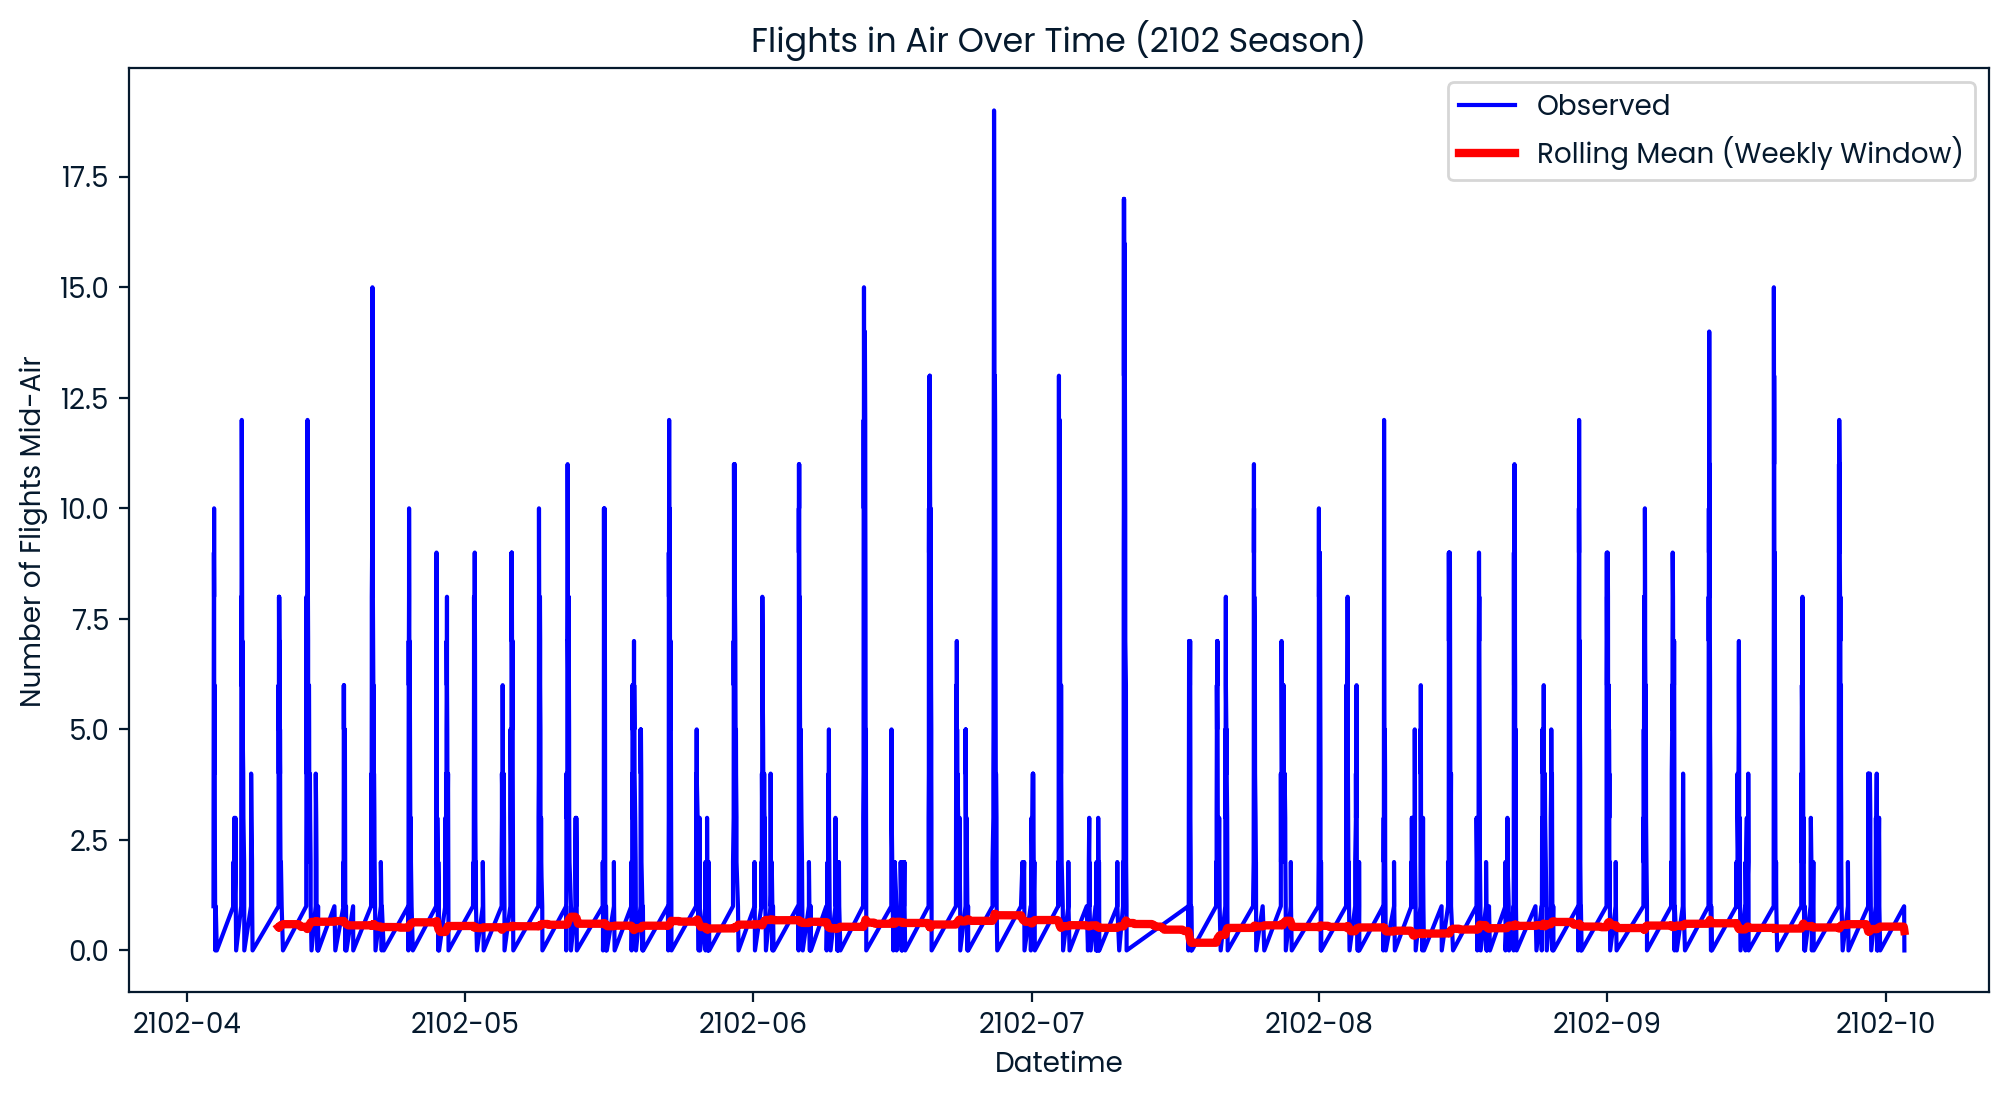

In [93]:
# Start coding here!
### Visualize the number of teams simultaneously flying

# Create a DataFrame for departure events with a +1 count
departure_events = team_flights[["departure_datetime"]].copy()
departure_events.rename(columns={"departure_datetime": "datetime"}, inplace=True)
departure_events["count"] = 1

# Create a DataFrame for landing events with a -1 count
landing_events = team_flights[["landing_datetime"]].copy()
landing_events.rename(columns={"landing_datetime": "datetime"}, inplace=True)
landing_events["count"] = -1

# Concatenate departure and landing events into a single DataFrame
events = pd.concat([departure_events, landing_events])
print(events.head())
print(events.describe())


# Sort the events by datetime
events = events.sort_values("datetime")

# Calculate the cumulative sum to get the number of flights mid-air at each event time
events["number_in_air"] = events["count"].cumsum()
print(events.head())

# Creating the trend series
events_series = events.groupby("datetime")["number_in_air"].last()
trend_series = events_series.asfreq('15T').dropna()
trend_rolling = regular_series.rolling(window=672).mean()


# Determine the maximum number of teams simultaneously in flight
max_teams_in_flight = int(events["number_in_air"].max())
print("Maximum teams in flight:", max_teams_in_flight)

# Visualization: Plot the number of flights mid-air over time using a step plot.
plt.figure(figsize=(12, 6))
plt.plot(events["datetime"], events["number_in_air"], color='blue', label = "Observed")
plt.plot(trend_rolling.index, trend_rolling, label='Rolling Mean (Weekly Window)', linewidth=3, color='red')
plt.xlabel("Datetime")
plt.ylabel("Number of Flights Mid-Air")
plt.title("Flights in Air Over Time (2102 Season)")
plt.legend()
plt.show()





date
2101-01-01    0.97
2101-01-02    0.87
2101-01-03    0.87
2101-01-04    0.97
2101-01-05    1.10
              ... 
2101-12-27    1.33
2101-12-28    1.46
2101-12-29    1.51
2101-12-30    1.46
2101-12-31    1.33
Freq: D, Name: price, Length: 365, dtype: float64


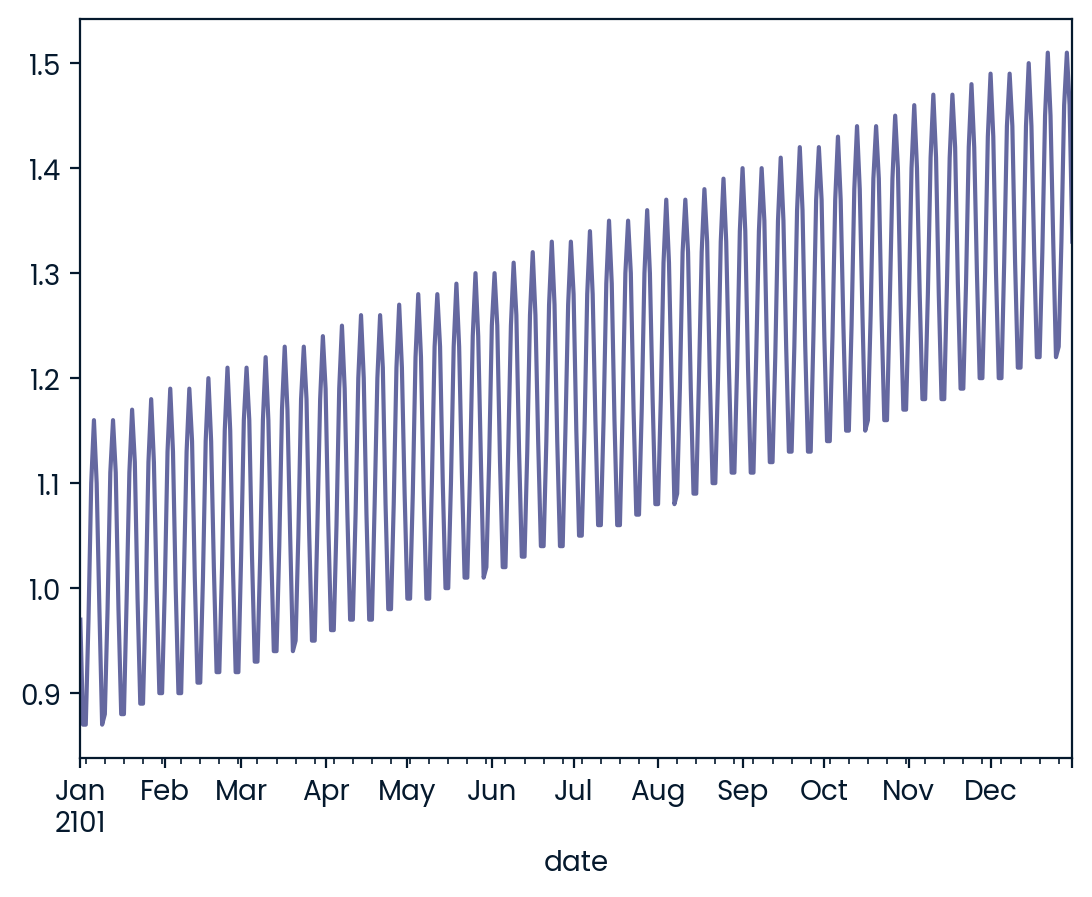

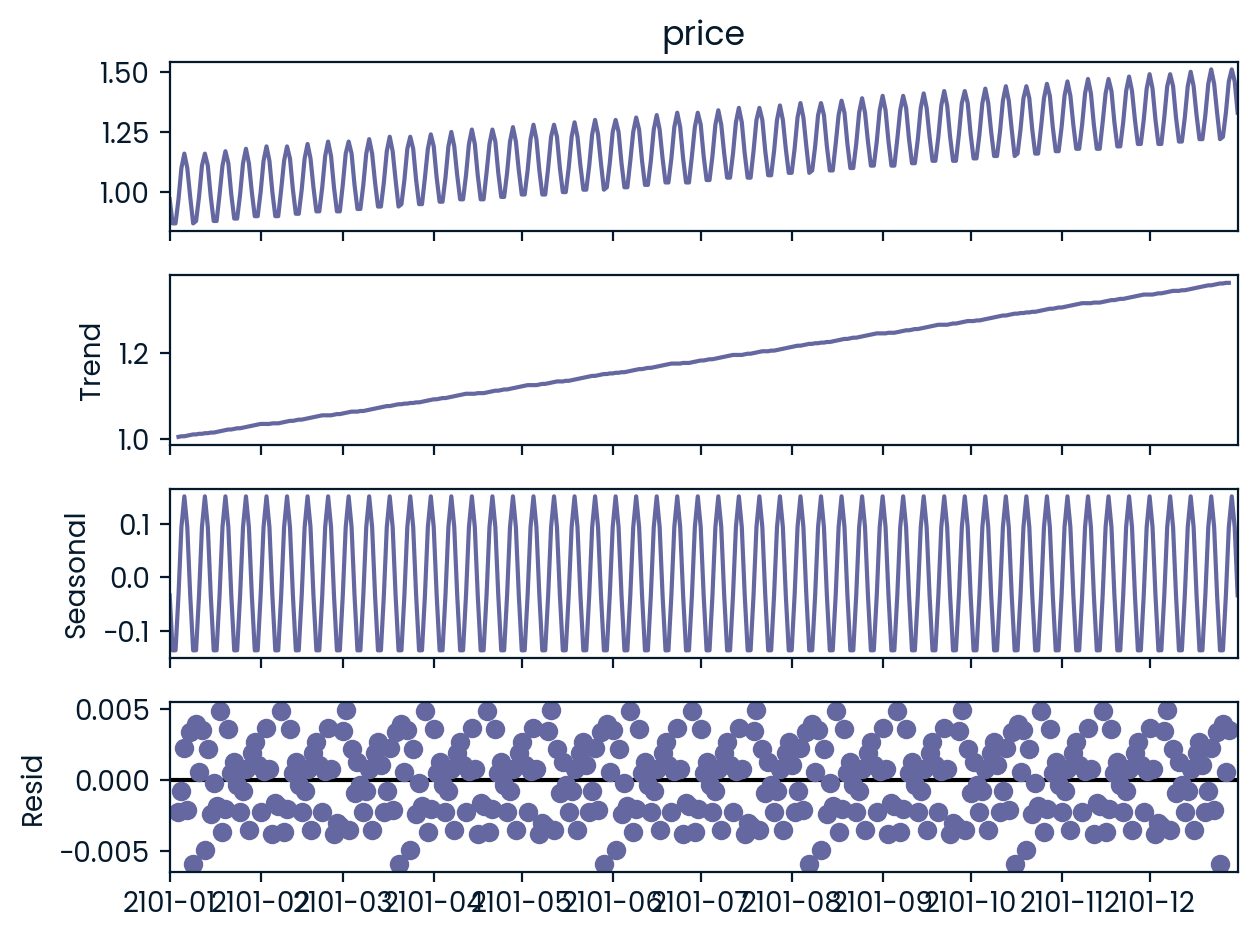

<Figure size 1200x400 with 0 Axes>

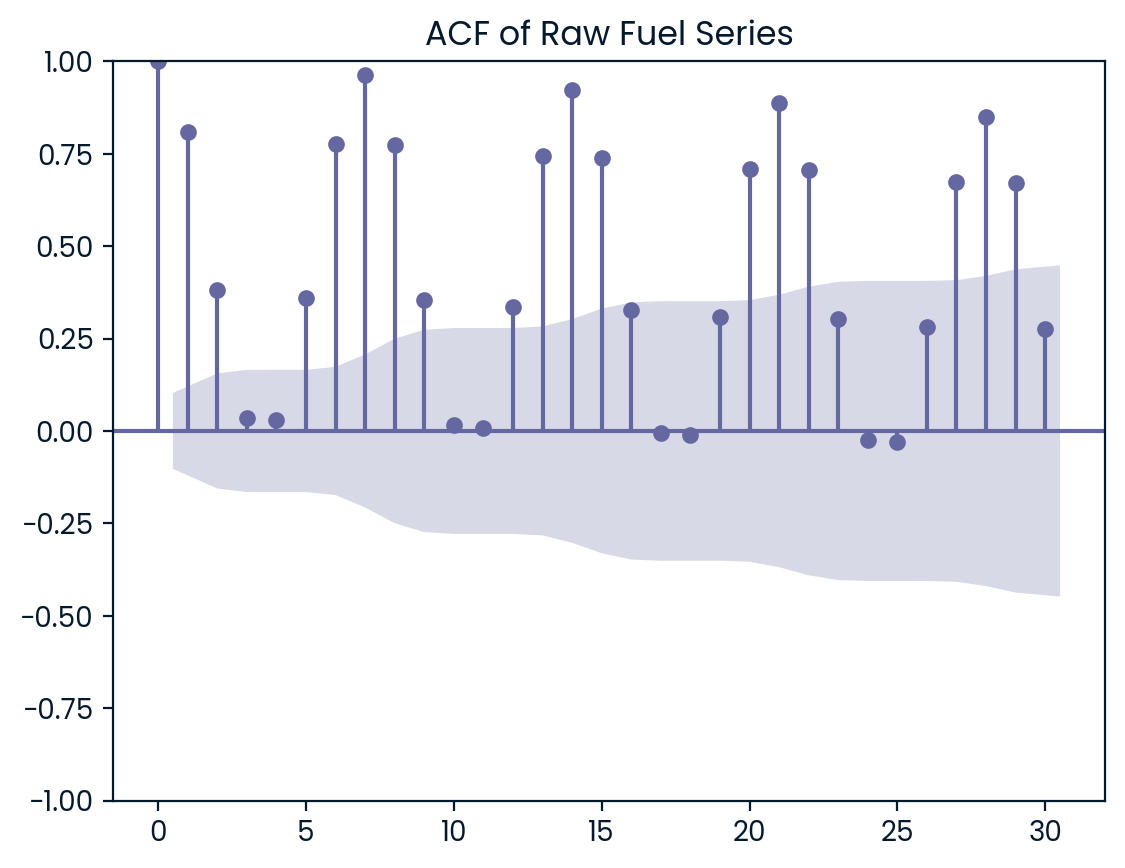

<Figure size 1200x400 with 0 Axes>

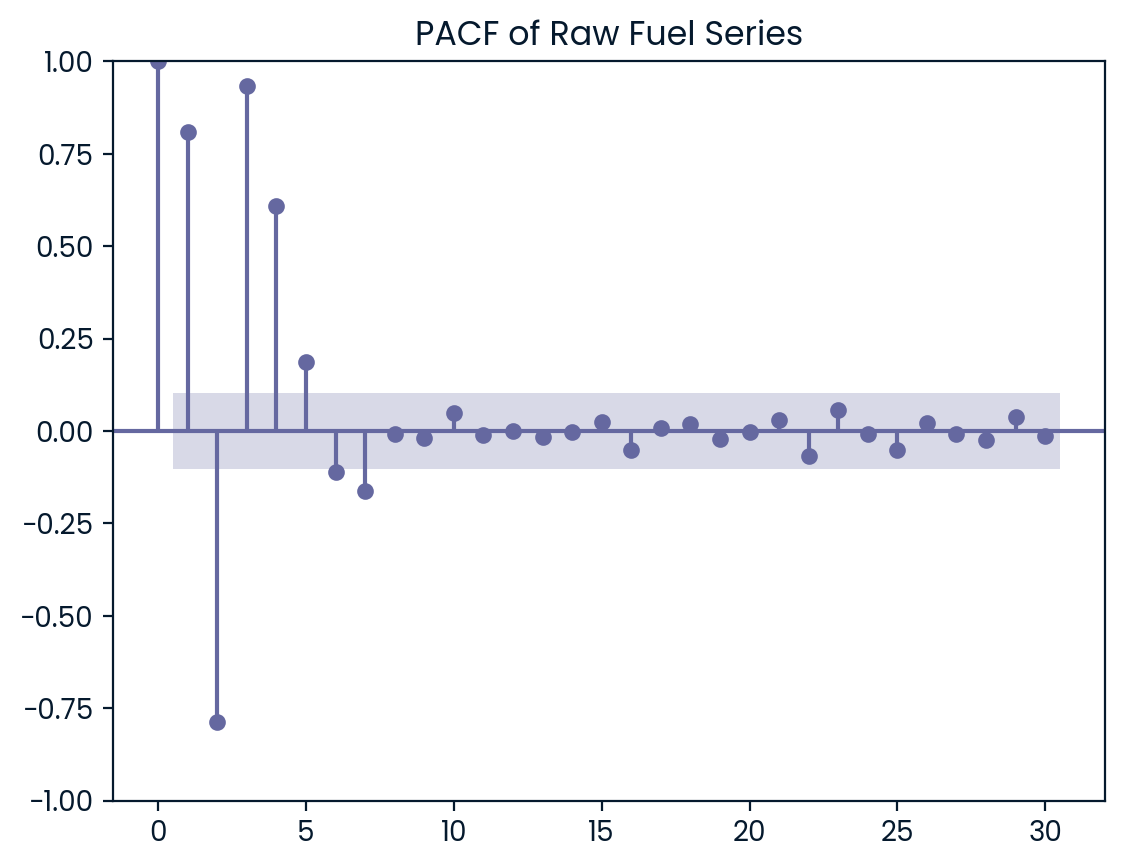

<Figure size 1200x400 with 0 Axes>

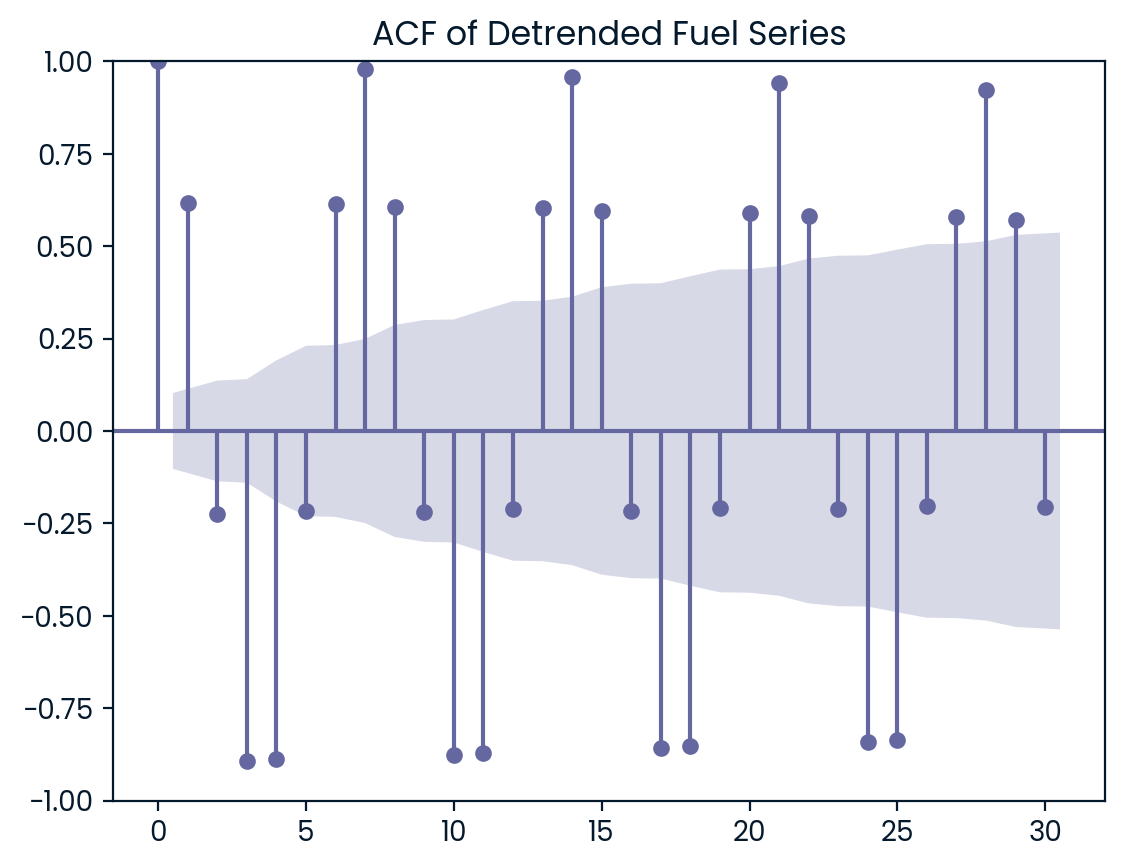

<Figure size 1200x400 with 0 Axes>

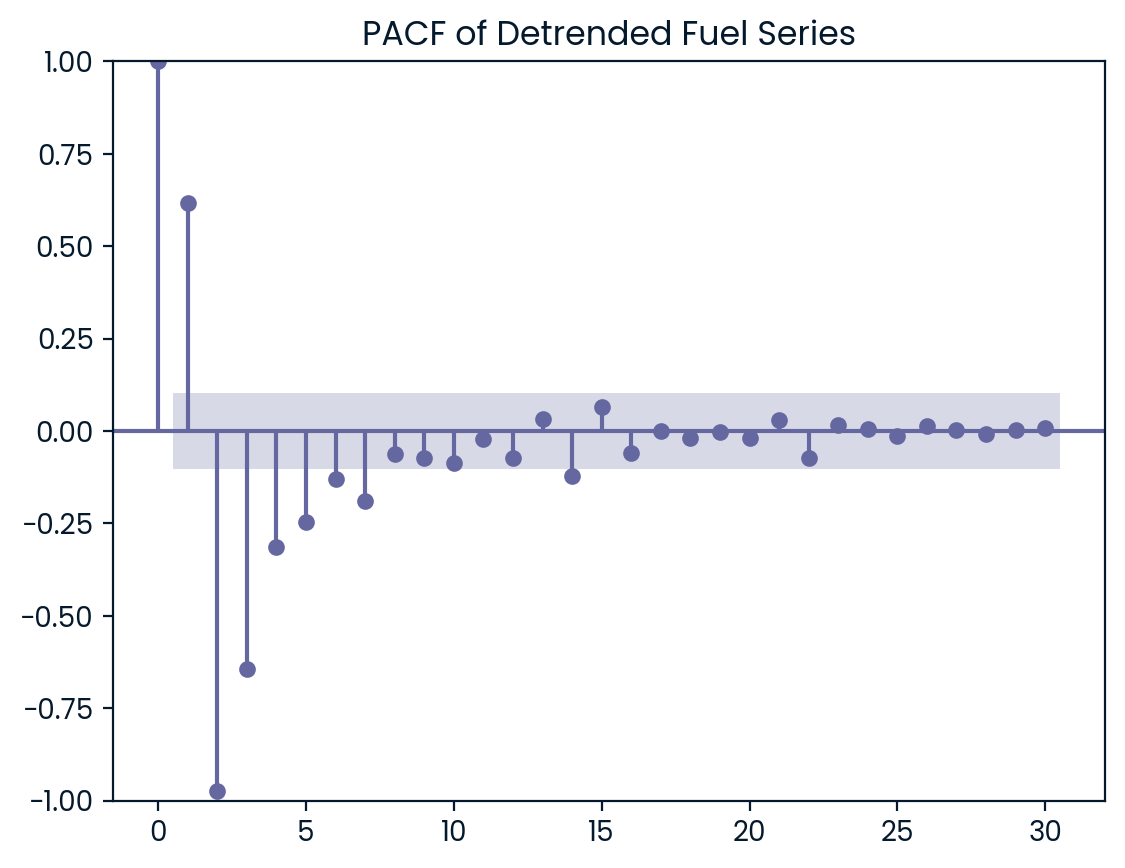

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Ensure that the series is daily
fuel_series= fuel_prices
fuel_series.index = fuel_series.index.to_timestamp()
fuel_series = fuel_series["price"].asfreq('D')
fuel_series.plot()
print(fuel_series)

# Decompose data
decomp_results = seasonal_decompose(fuel_series, period=7)
decomp_results.plot()
plt.show()



#  Plot ACF/PACF of the raw series (might show trend/seasonal effects)
plt.figure(figsize=(12, 4))
plot_acf(fuel_series, lags=30, alpha=0.05)
plt.title("ACF of Raw Fuel Series")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(fuel_series, lags=30, alpha=0.05)
plt.title("PACF of Raw Fuel Series")
plt.show()

#Detrend the series via differencing (to focus on the stationary component)
detrended_series = fuel_series.diff().dropna()


plt.figure(figsize=(12, 4))
plot_acf(detrended_series, lags=30, alpha=0.05)
plt.title("ACF of Detrended Fuel Series")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(detrended_series, lags=30, alpha=0.05)
plt.title("PACF of Detrended Fuel Series")
plt.show()



from pmdarima import auto_arima

# Sarima with auto_arima

# stepwise_model = auto_arima(
#     fuel_series,
#     start_p=0, max_p=4,       # Range of AR orders
#     start_q=0, max_q=4,       # Range of MA orders
#     d=1,                   
#     start_P=0, max_P=4,       # Range of seasonal AR orders
#     start_Q=0, max_Q=4,       # Range of seasonal MA orders
#     D=1,                   
#     seasonal=True,
#     m=7,                      # Weekly seasonality
#     trace=True,               # Print model fitting progress
#     error_action='ignore',    # Ignore non-invertible models
#     suppress_warnings=True,
#     stepwise=True
# )

# print(stepwise_model.summary())



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.03284D+00    |proj g|=  1.10453D+02


 This problem is unconstrained.



At iterate    5    f= -4.17554D+00    |proj g|=  9.69514D-02
  ys=-5.903E-11  -gs= 7.569E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     39      1     1     0   1.025D-01  -4.176D+00
  F =  -4.1755435531444594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


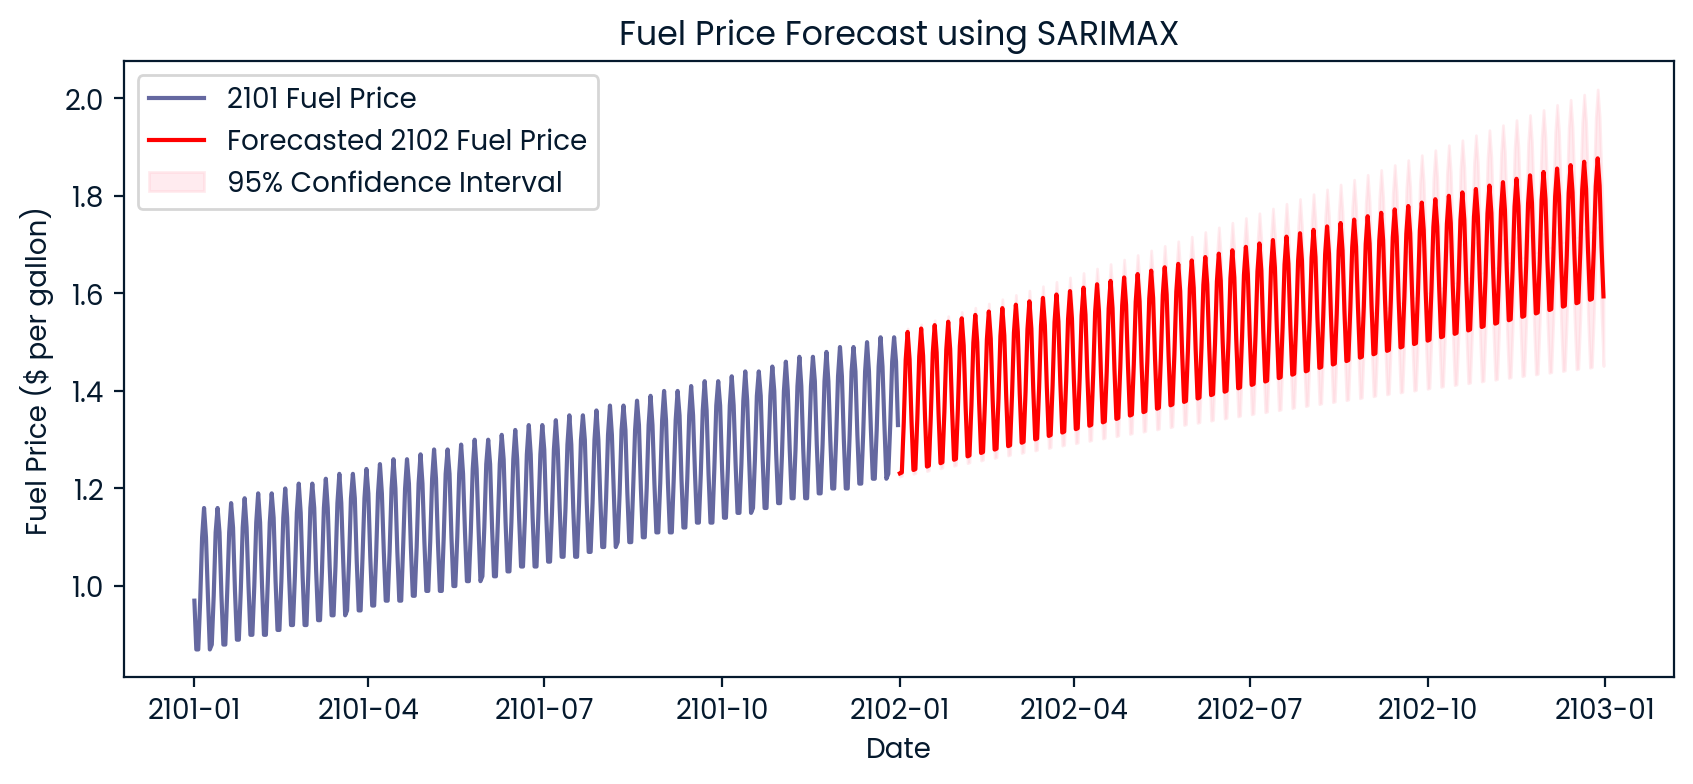

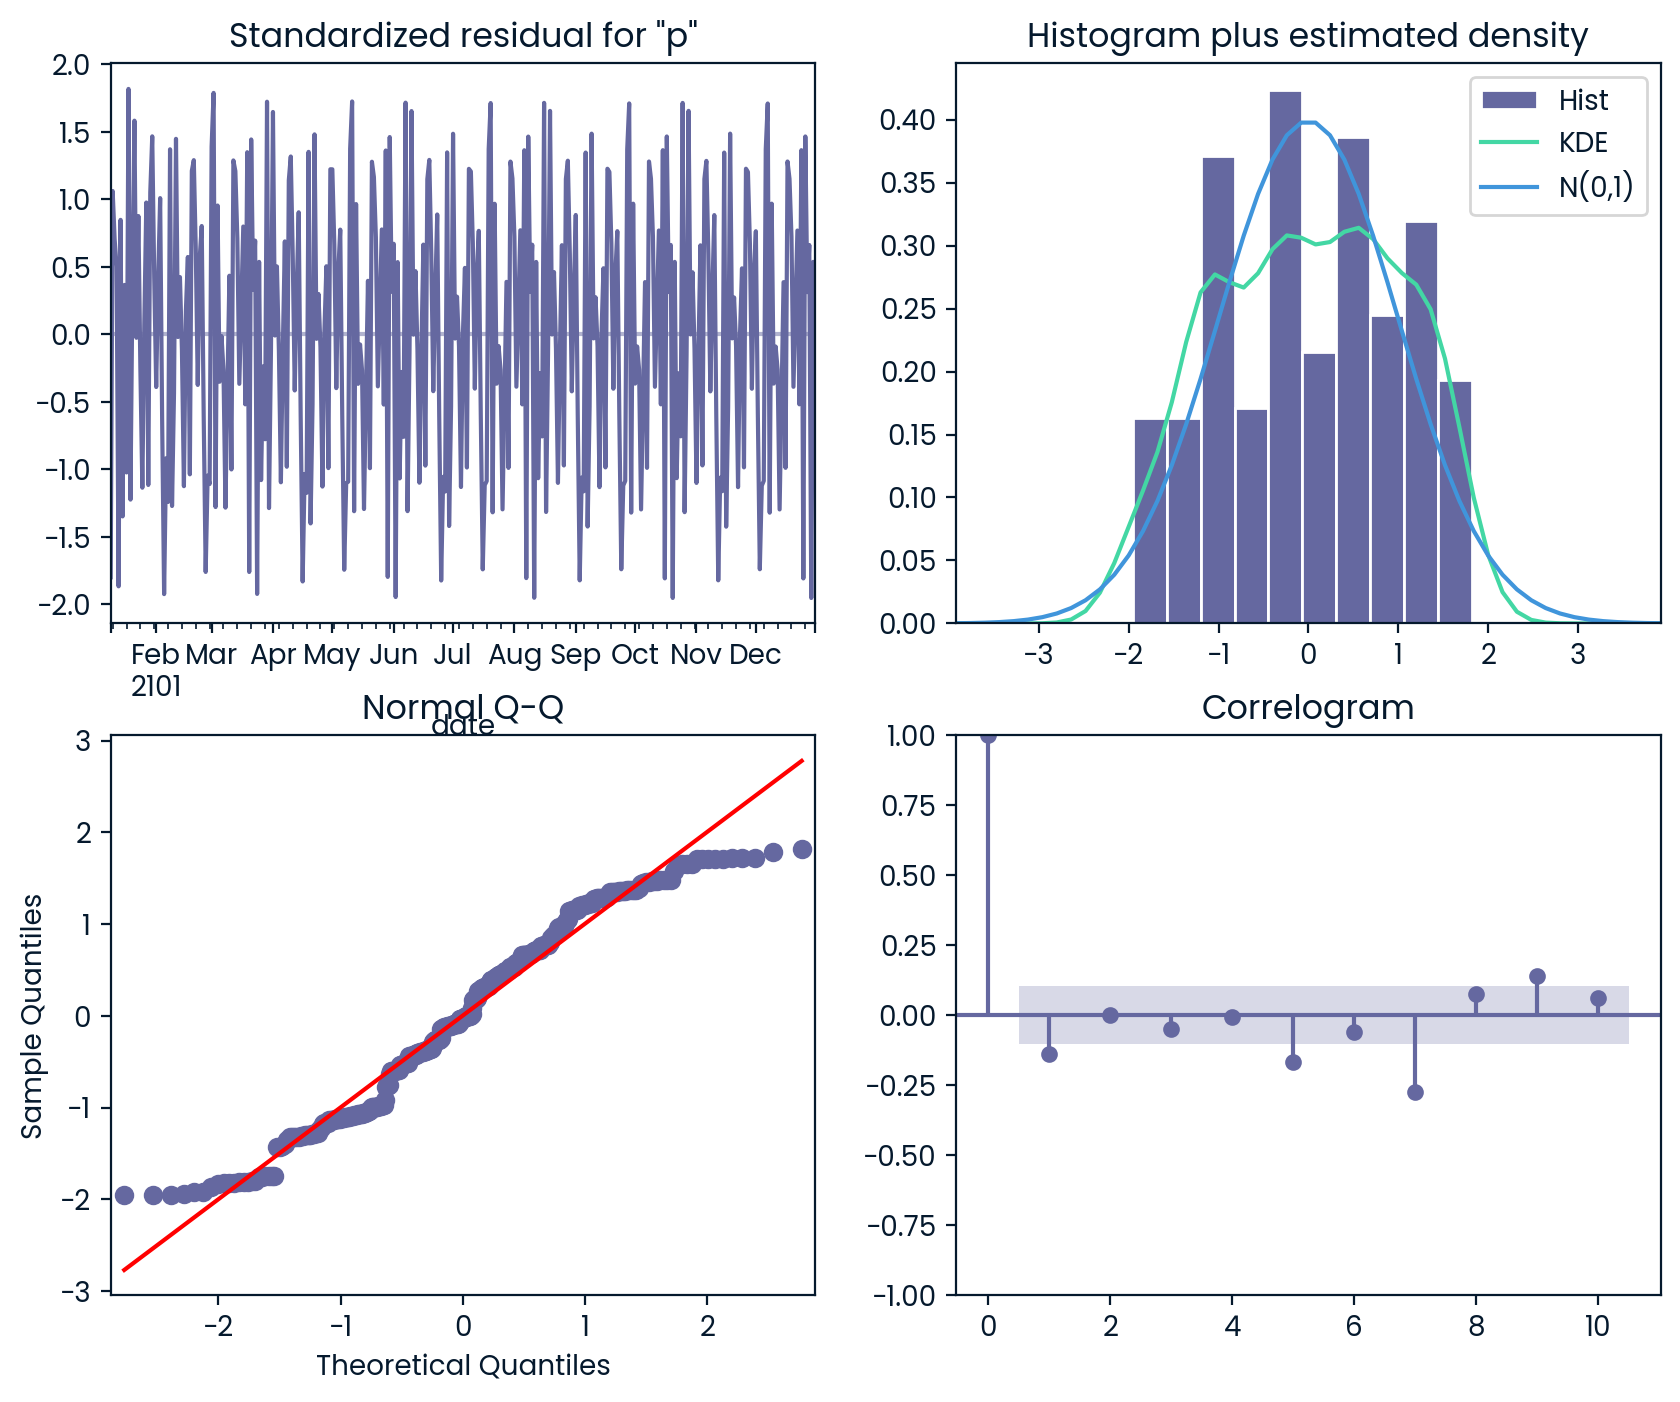

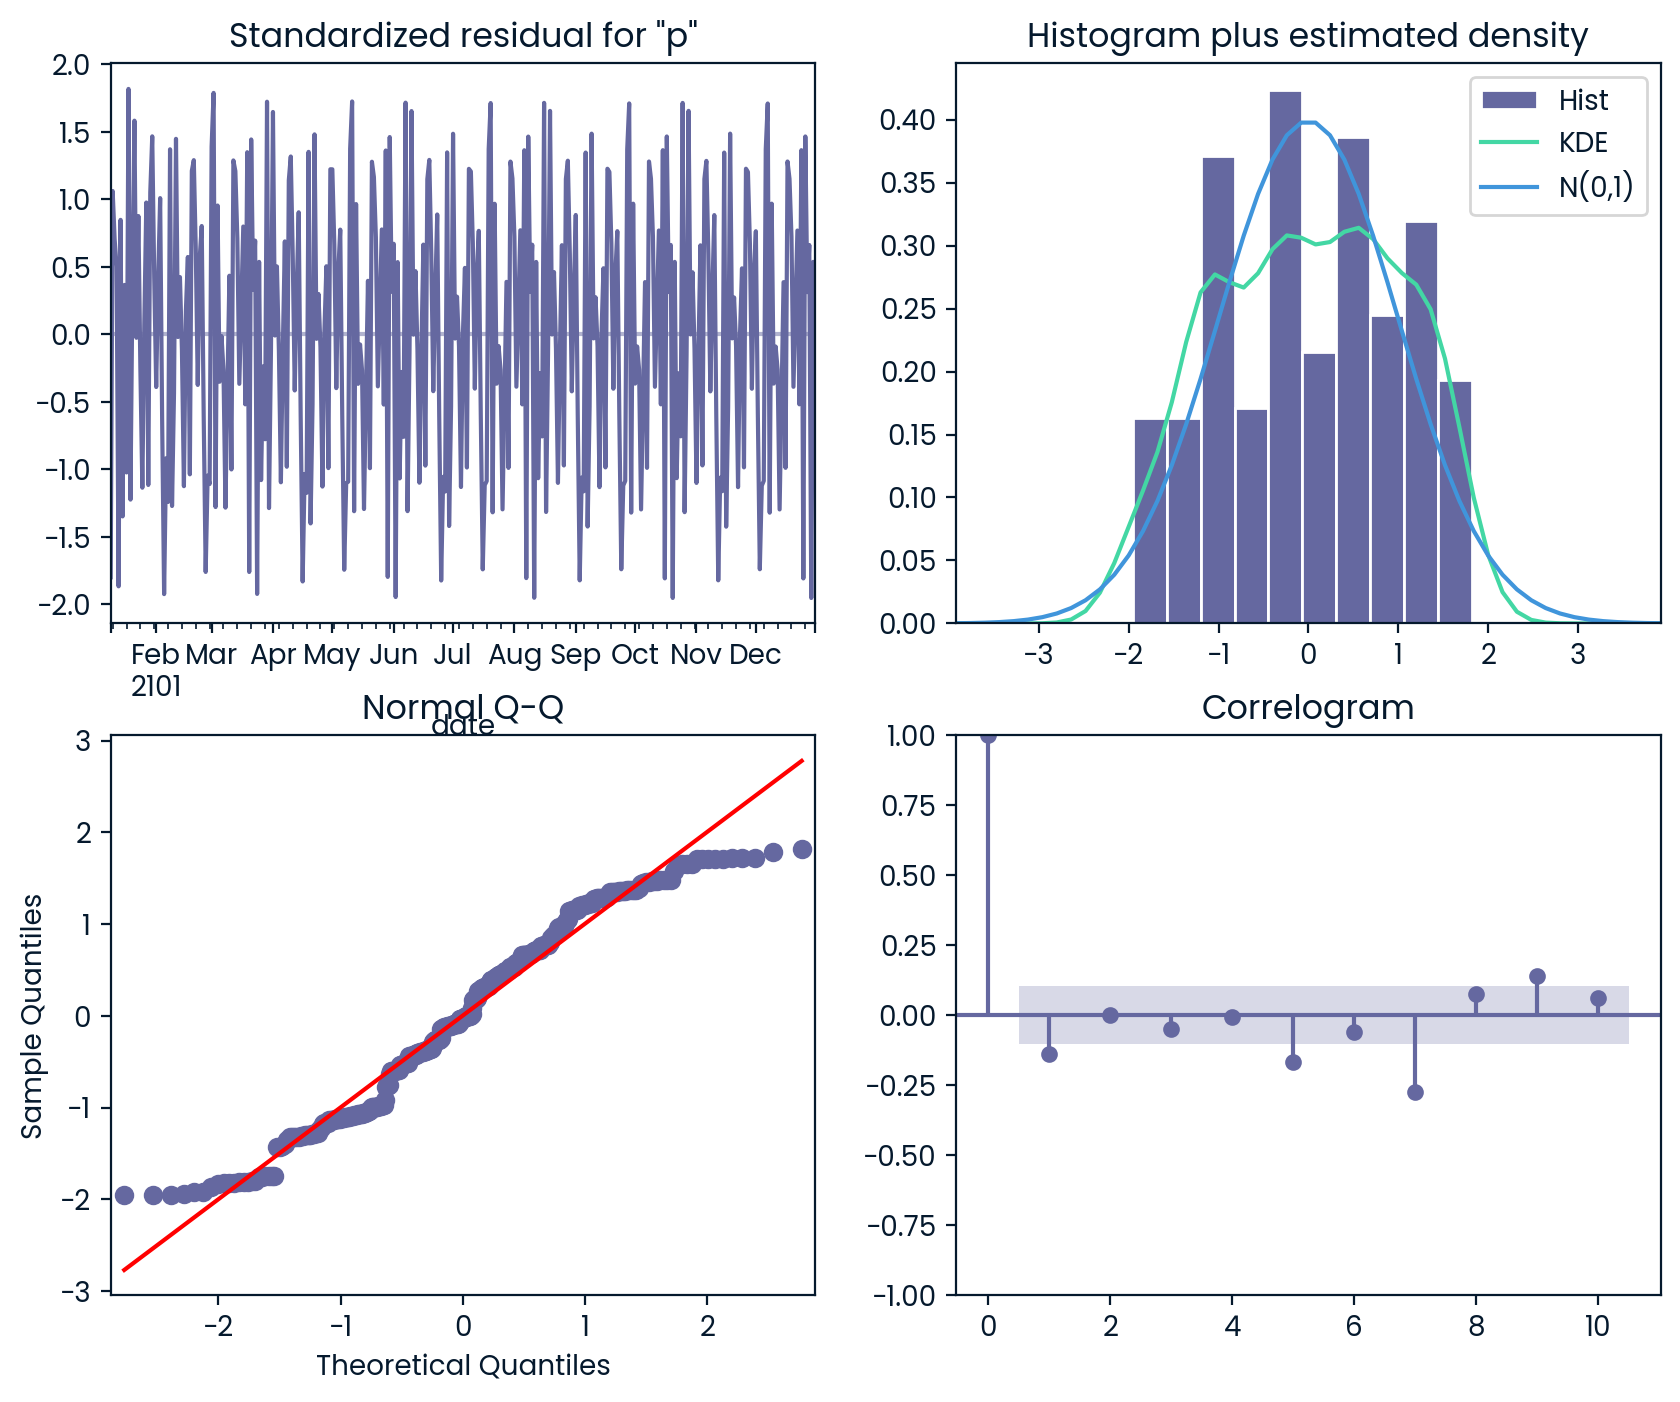

In [95]:
# Here we choose order=(0, 1, 1) and seasonal_order=(0, 1, 1, 7) 
model = SARIMAX(fuel_series, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
model_fit = model.fit()

# --- Step 3: Forecast Fuel Prices for 2102 ---
# Create a date range for 2102
future_dates = pd.date_range(start="2102-01-01", end="2102-12-31", freq='D')
forecast_steps = len(future_dates)

# Generate forecasted values using the fitted model
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

# Rename the forecast column and set the index to our future dates
forecast_df = forecast_df.rename(columns={'mean': 'fuel_price'})
forecast_df.index = future_dates

# Optional: visualize the forecast
plt.figure(figsize=(10,4))
plt.plot(fuel_series.index, fuel_series, label="2101 Fuel Price")
plt.plot(forecast_df.index, forecast_df["fuel_price"], label="Forecasted 2102 Fuel Price", color='red')

# Add the confidence interval as a shaded area
plt.fill_between(
    forecast_df.index,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color='pink',
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.xlabel("Date")
plt.ylabel("Fuel Price ($ per gallon)")
plt.title("Fuel Price Forecast using SARIMAX")
plt.legend()
plt.show()
model_fit.plot_diagnostics(figsize=(10, 8))

In [96]:
# Make sure the departure_date in flight data is of type datetime.date
team_flights["departure_date"] = team_flights["departure_datetime"].dt.date

# Reset the forecast index and convert to date for merging
forecast_df_reset = forecast_df.reset_index().rename(columns={'index': 'date'})
forecast_df_reset["date"] = forecast_df_reset["date"].dt.date

# Merge the flight data with the forecasted fuel prices
team_flights = team_flights.merge(forecast_df_reset[["date", "fuel_price"]], 
                                  left_on="departure_date", right_on="date", how="left")


# Compute flight duration (in hours) and then distance (in miles)
team_flights["flight_duration_hours"] = (team_flights["landing_datetime"] - team_flights["departure_datetime"]).dt.total_seconds() / 3600.0
team_flights["distance_miles"] = team_flights["flight_duration_hours"] * 500
team_flights["fuel_consumption_gallons"] = team_flights["distance_miles"]

# Calculate the fuel cost for each flight
team_flights["flight_fuel_cost"] = team_flights["fuel_consumption_gallons"] * team_flights["fuel_price"]

# Sum the costs to get the total fuel spend for 2102
total_fuel_spend_2102_dollars = team_flights["flight_fuel_cost"].sum()
print("Total fuel spend for 2102 (in dollars):", total_fuel_spend_2102_dollars)

Total fuel spend for 2102 (in dollars): 1867124.1022432295
